In [1]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

In [2]:
df = pd.read_csv('0hp_all_faults.csv')

In [3]:
df.shape

(2782629, 2)

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Parametry okna i przesunięcia
win_len=784
stride=300

# Inicjalizacja list do przechowywania segmentów danych i etykiet
X=[]
Y=[]

# Przetwarzanie danych dla każdej unikalnej wartości w kolumnie 'fault'
for k in df['fault'].unique():
    
    # Filtracja danych dla bieżącej wartości 'fault'
    df_temp_2 = df[df['fault']==k]
    
    # Ekstrakcja segmentów danych o długości 'win_len' przesuwanych o 'stride'
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        # Pobieranie segmentu danych i przekształcanie go do odpowiedniego formatu
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp) # Dodawanie segmentu do listy X
        Y.append(df_temp_2.iloc[i+win_len,-1]) # Dodawanie etykiety do listy Y
        
# Konwersja list X i Y do tablic numpy    
X=np.array(X)
X=X.reshape((X.shape[0],28,28,1)) # Przekształcenie do formatu (liczba_segmentów, 28, 28, 1)

Y=np.array(Y)  # Konwersja listy Y do tablicy numpy

# Kodowanie etykiet za pomocą LabelEncoder
encoder= LabelEncoder()
encoder.fit(Y) # Dopasowanie encoder'a do etykiet
encoded_Y = encoder.transform(Y) # Transformacja etykiet do wartości numerycznych
OHE_Y = to_categorical(encoded_Y)  # Konwersja etykiet do postaci one-hot

In [5]:
X.shape

(9246, 28, 28, 1)

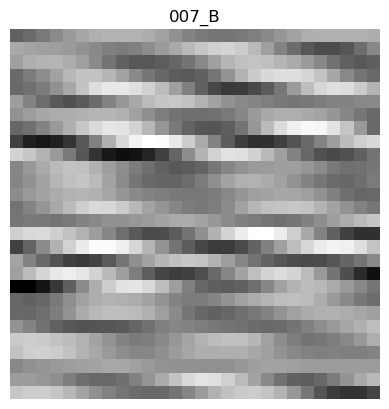

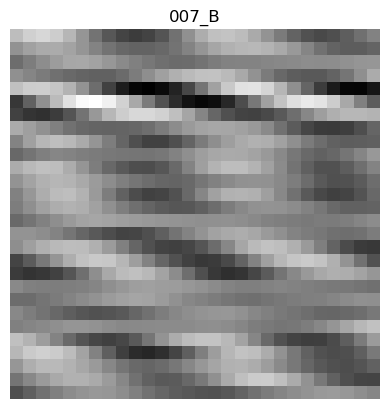

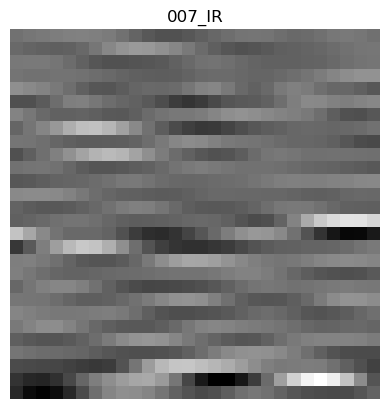

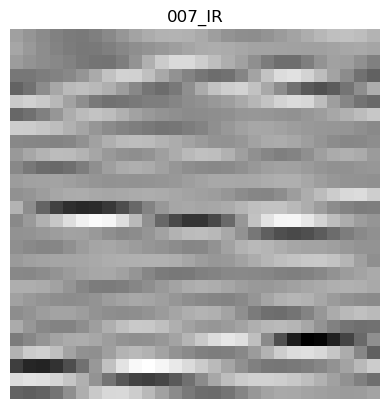

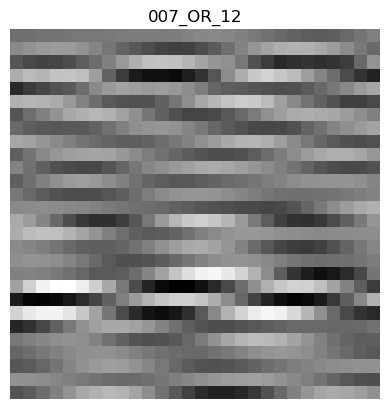

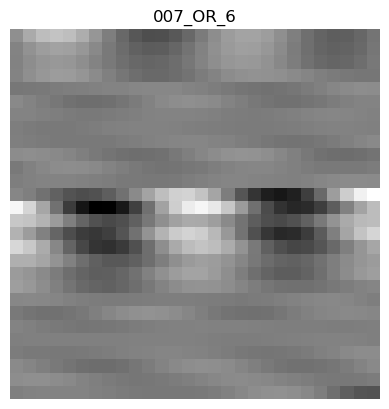

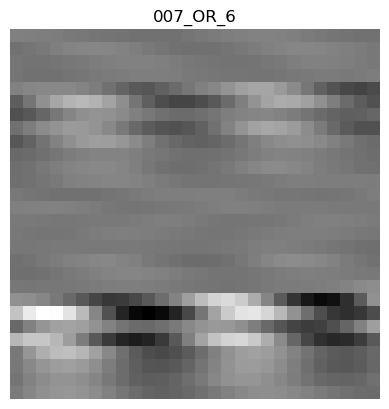

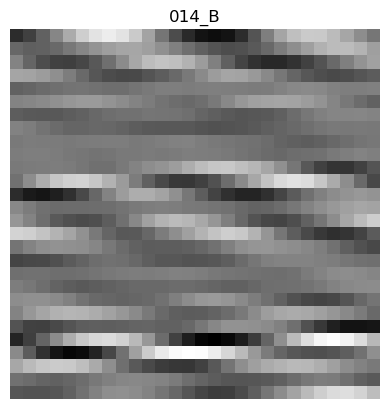

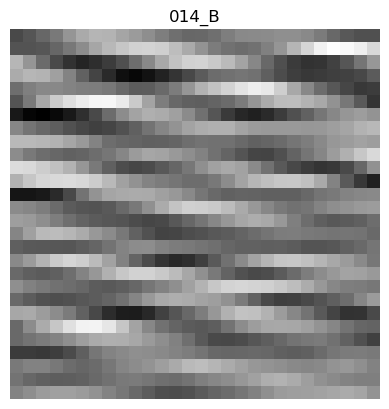

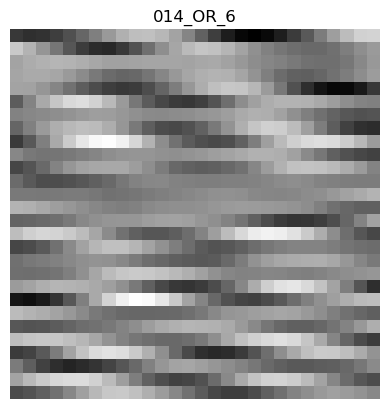

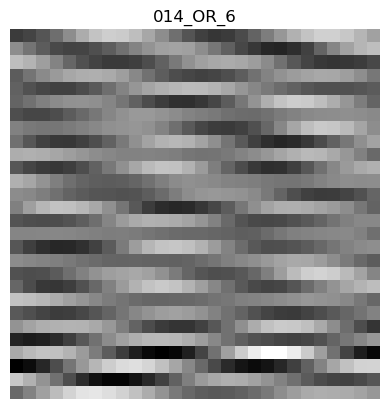

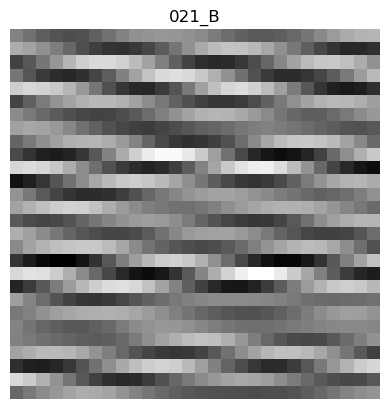

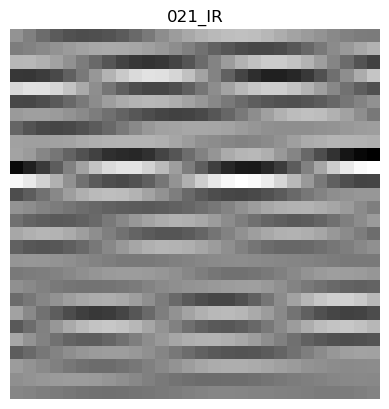

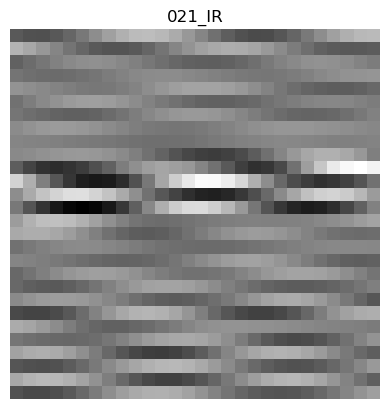

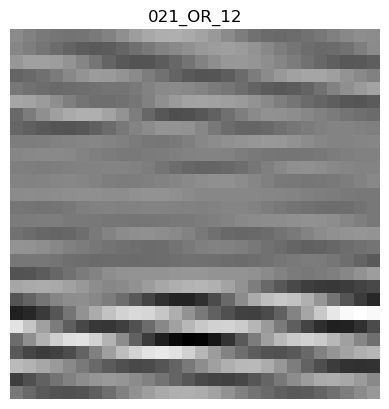

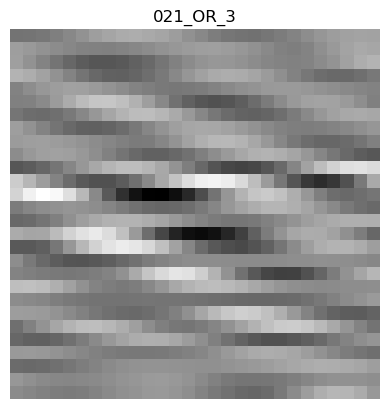

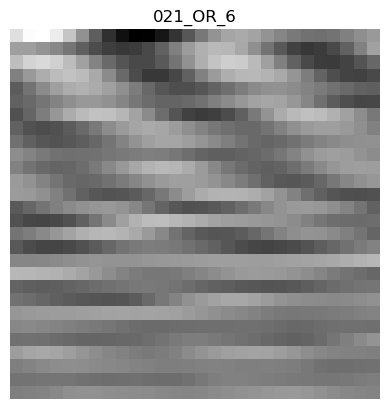

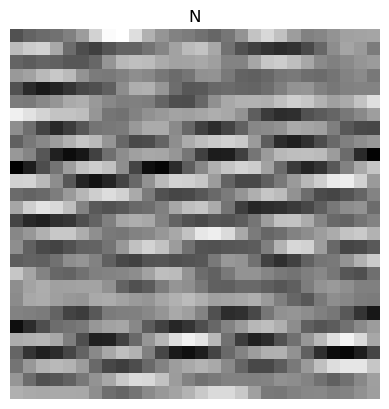

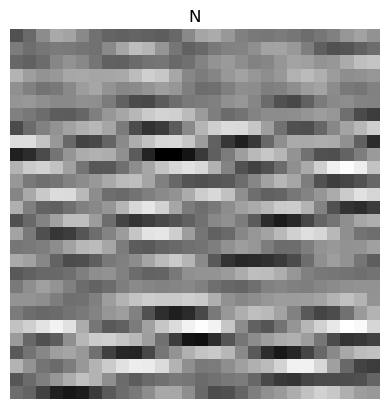

In [6]:
from matplotlib.pyplot import imread

# Pętla przez wybrane indeksy segmentów
# range(0, 9244, 500) oznacza, że pętla przechodzi przez indeksy od 0 do 9244 z krokiem 500
for idx in range(0,9244,500):
    img=X[idx]
    # Wyświetlanie obrazu za pomocą matplotlib
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [7]:
from sklearn.model_selection import train_test_split
# Podział danych na zbiory treningowy i testowy
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          51232     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 120)               6

In [10]:
# Definicja wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trening modelu z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodanie wczesnego zatrzymywania do listy callbacks
)

Epoch 1/80
17/17 [==============================] - 5s 223ms/step - loss: 2.2510 - accuracy: 0.1998 - val_loss: 1.8079 - val_accuracy: 0.3872
Epoch 2/80
17/17 [==============================] - 3s 199ms/step - loss: 1.4973 - accuracy: 0.4906 - val_loss: 1.2359 - val_accuracy: 0.5692
Epoch 3/80
17/17 [==============================] - 4s 211ms/step - loss: 1.0116 - accuracy: 0.6802 - val_loss: 0.8950 - val_accuracy: 0.7722
Epoch 4/80
17/17 [==============================] - 3s 205ms/step - loss: 0.6731 - accuracy: 0.8158 - val_loss: 0.5350 - val_accuracy: 0.8580
Epoch 5/80
17/17 [==============================] - 4s 212ms/step - loss: 0.4115 - accuracy: 0.8792 - val_loss: 0.3041 - val_accuracy: 0.9160
Epoch 6/80
17/17 [==============================] - 4s 220ms/step - loss: 0.2516 - accuracy: 0.9268 - val_loss: 0.2375 - val_accuracy: 0.9283
Epoch 7/80
17/17 [==============================] - 4s 224ms/step - loss: 0.1917 - accuracy: 0.9380 - val_loss: 0.1877 - val_accuracy: 0.9362
Epoch 

87/87 [==============================] - 1s 9ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

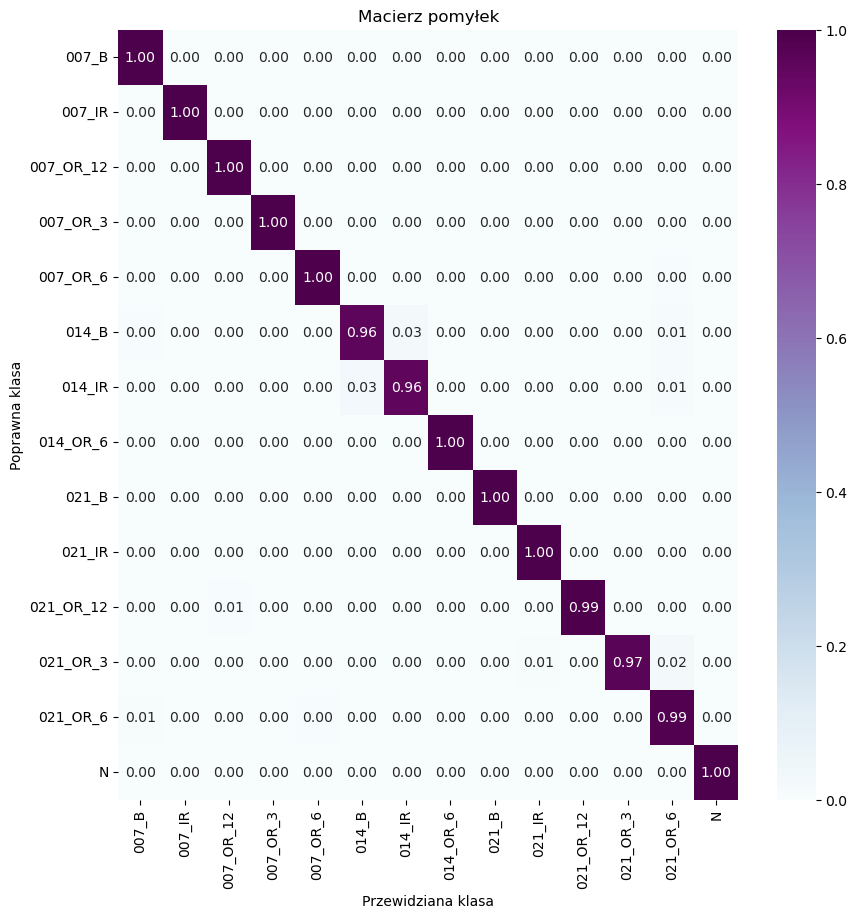

In [11]:
from sklearn.metrics import confusion_matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1) # Przekształcanie predykcji z formatu one-hot na etykiety klas
    y_pred = encoder.inverse_transform(y_pred) # Inwersja kodowania etykiet na oryginalne wartości
    return y_pred

y_pred=cnn_model.predict(X_test) # Generowanie predykcji modelu

# Przekształcanie wyników predykcji i prawdziwych etykiet
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)

# Tworzenie macierzy pomyłek
plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True ,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [12]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, Y_pred)
print(score)

0.9913482335976929


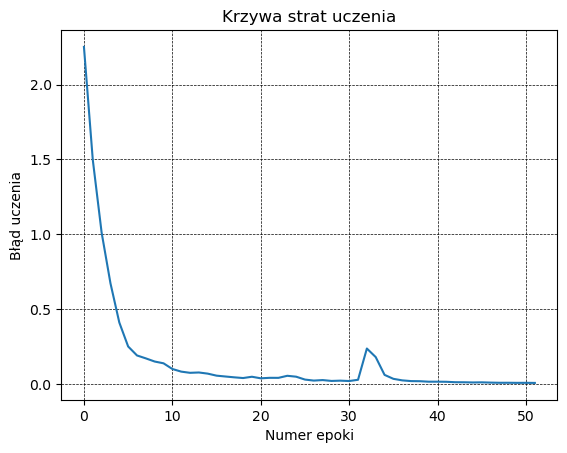

In [13]:
# Wyświetlanie krzywej strat uczenia
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

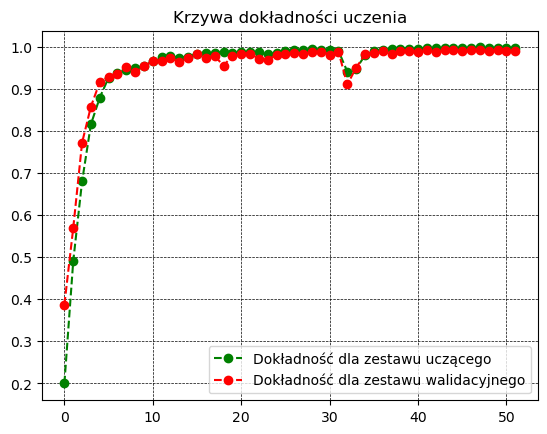

In [14]:
# Wyświetlanie krzywej dokładności uczenia
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

203/203 [==============================] - 2s 9ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6472 samples in 0.000s...
[t-SNE] Computed neighbors for 6472 samples in 0.615s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6472
[t-SNE] Computed conditional probabilities for sample 2000 / 6472
[t-SNE] Computed conditional probabilities for sample 3000 / 6472
[t-SNE] Computed conditional probabilities for sample 4000 / 6472
[t-SNE] Computed conditional probabilities for sample 5000 / 6472
[t-SNE] Computed conditional probabilities for sample 6000 / 6472
[t-SNE] Computed conditional probabilities for sample 6472 / 6472
[t-SNE] Mean sigma: 1.770067
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.202782
[t-SNE] KL divergence after 300 iterations: 1.933565


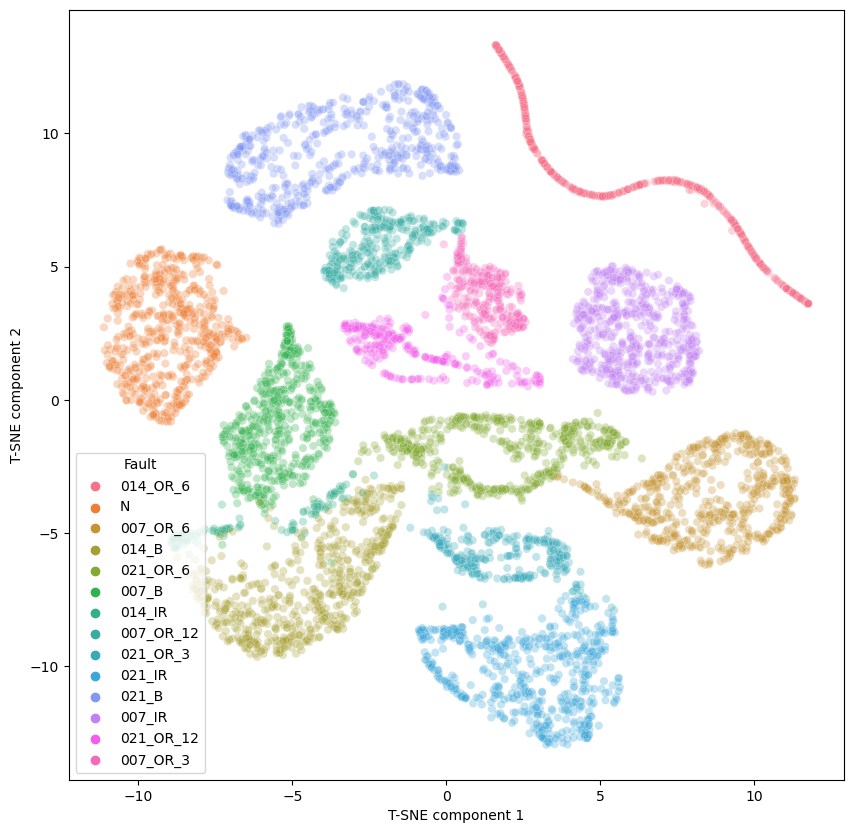

In [15]:
from sklearn.manifold import TSNE

# Tworzenie modelu pomocniczego, który zwraca wyjście z piątej warstwy oryginalnego modelu CNN
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)

# Przepuszczanie danych treningowych przez pomocniczy model, aby uzyskać wyniki z piątej warstwy
y_viz = dummy_cnn.predict(X_train)

# Użycie algorytmu t-SNE do redukcji wymiarowości danych wyjściowych do dwóch wymiarów
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

# Tworzenie DataFrame z wynikami t-SNE, z kolumnami dla dwóch wymiarów t-SNE
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

# Przekształcanie etykiet z formatu one-hot do oryginalnych etykiet i dodawanie ich do DataFrame
tSNEdf['Fault']=inv_Transform_result(y_train)


# Wizualizacja wyników t-SNE za pomocą wykresu punktowego
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [16]:
df = pd.read_csv('1hp_all_faults.csv')

In [17]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Parametry okna i przesunięcia
win_len=784
stride=300

# Inicjalizacja list do przechowywania segmentów danych i etykiet
X=[]
Y=[]

# Przetwarzanie danych dla każdej unikalnej wartości w kolumnie 'fault'
for k in df['fault'].unique():
    
    # Filtracja danych dla bieżącej wartości 'fault'
    df_temp_2 = df[df['fault']==k]
    
    # Ekstrakcja segmentów danych o długości 'win_len' przesuwanych o 'stride'
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        # Pobieranie segmentu danych i przekształcanie go do odpowiedniego formatu
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp) # Dodawanie segmentu do listy X
        Y.append(df_temp_2.iloc[i+win_len,-1]) # Dodawanie etykiety do listy Y
        
# Konwersja list X i Y do tablic numpy    
X=np.array(X)
X=X.reshape((X.shape[0],28,28,1)) # Przekształcenie do formatu (liczba_segmentów, 28, 28, 1)

Y=np.array(Y)  # Konwersja listy Y do tablicy numpy

# Kodowanie etykiet za pomocą LabelEncoder
encoder= LabelEncoder()
encoder.fit(Y) # Dopasowanie encoder'a do etykiet
encoded_Y = encoder.transform(Y) # Transformacja etykiet do wartości numerycznych
OHE_Y = to_categorical(encoded_Y)  # Konwersja etykiet do postaci one-hot

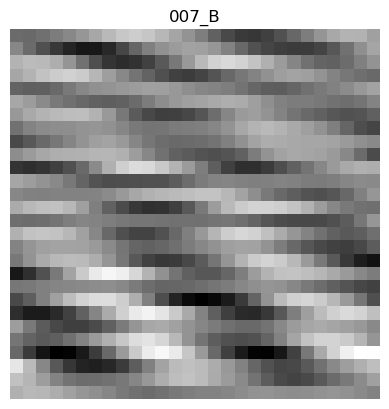

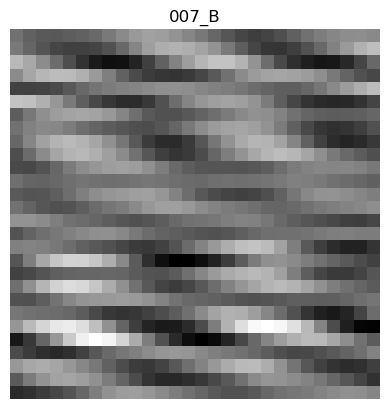

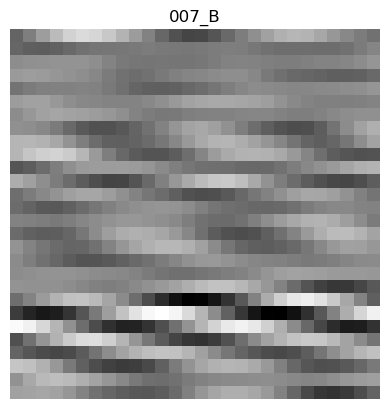

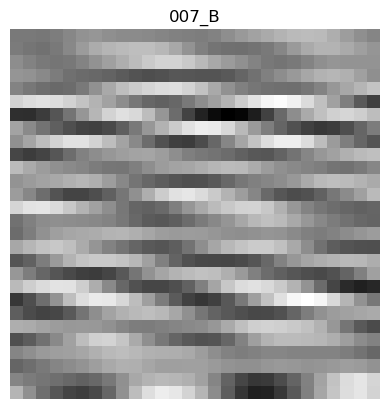

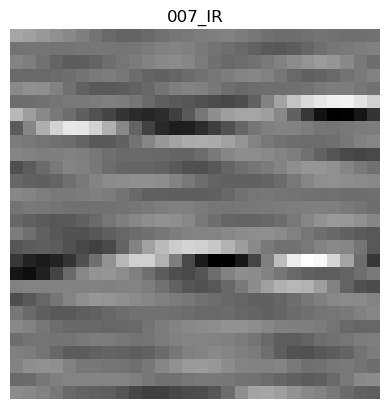

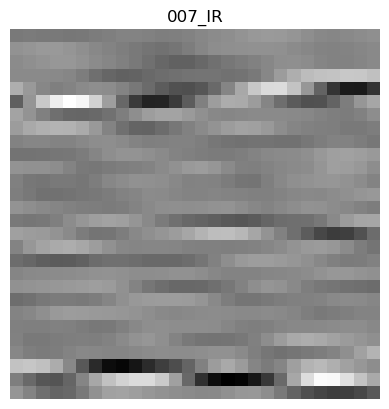

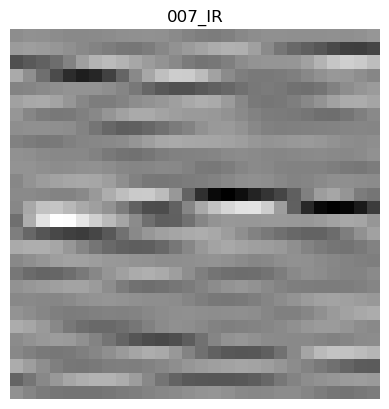

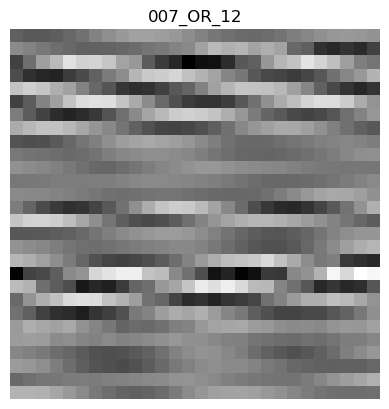

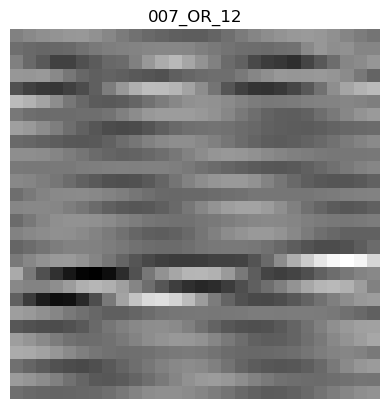

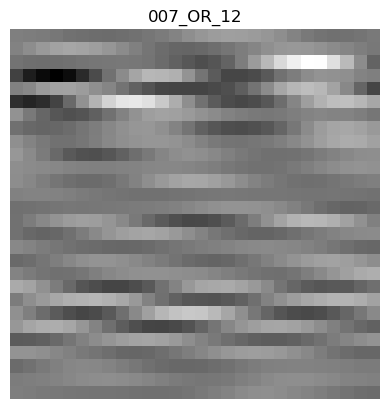

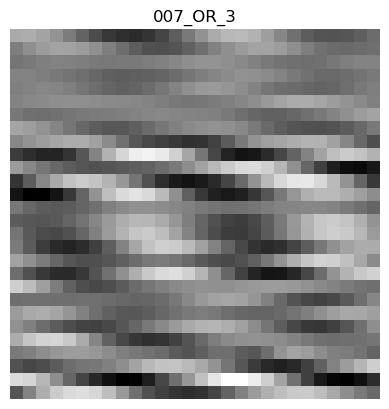

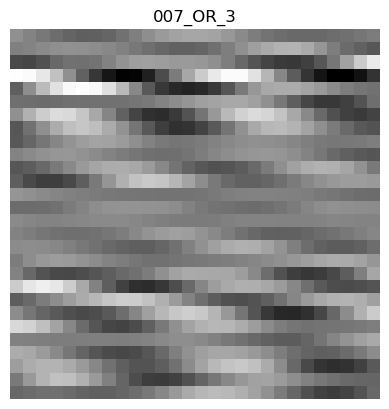

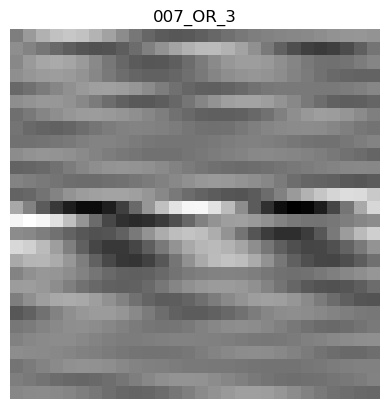

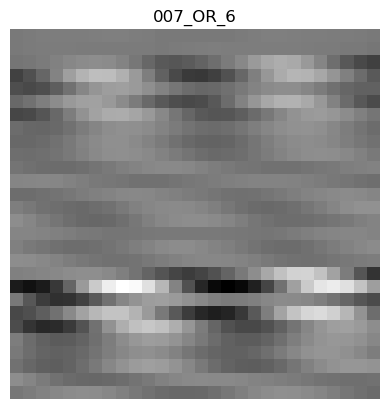

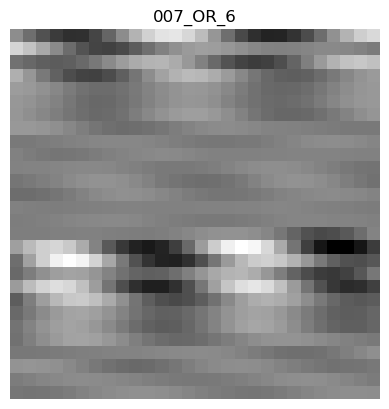

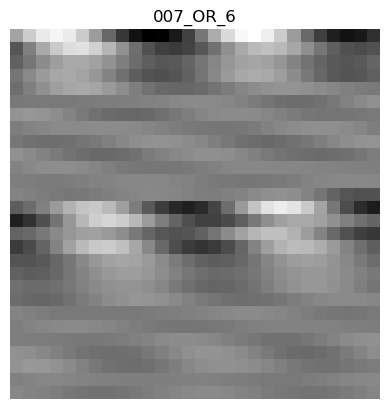

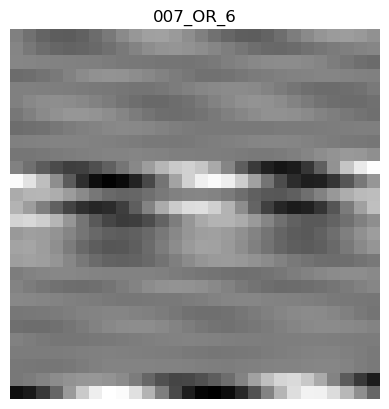

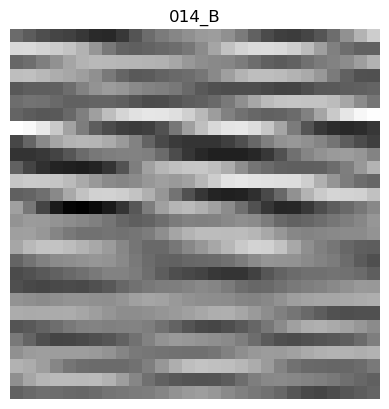

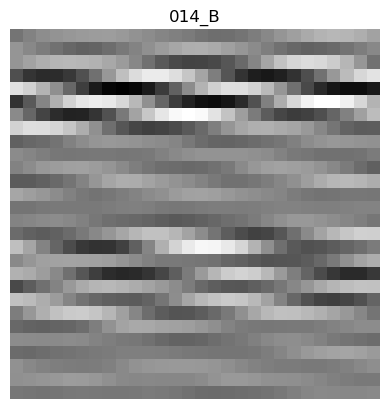

In [18]:
from matplotlib.pyplot import imread

# Pętla przez wybrane indeksy segmentów
# range(0, 9244, 500) oznacza, że pętla przechodzi przez indeksy od 0 do 9244 z krokiem 500
for idx in range(0,9244,500):
    img=X[idx]
    # Wyświetlanie obrazu za pomocą matplotlib
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [19]:
from sklearn.model_selection import train_test_split
# Podział danych na zbiory treningowy i testowy
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [20]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          51232     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [22]:
# Definicja wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trening modelu z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodanie wczesnego zatrzymywania do listy callbacks
)

Epoch 1/80
40/40 [==============================] - 11s 246ms/step - loss: 2.1325 - accuracy: 0.2516 - val_loss: 1.5786 - val_accuracy: 0.4715
Epoch 2/80
40/40 [==============================] - 10s 244ms/step - loss: 1.0290 - accuracy: 0.6815 - val_loss: 0.7568 - val_accuracy: 0.7419
Epoch 3/80
40/40 [==============================] - 10s 252ms/step - loss: 0.4778 - accuracy: 0.8352 - val_loss: 0.4220 - val_accuracy: 0.8641
Epoch 4/80
40/40 [==============================] - 10s 245ms/step - loss: 0.3258 - accuracy: 0.8870 - val_loss: 0.3035 - val_accuracy: 0.8971
Epoch 5/80
40/40 [==============================] - 10s 239ms/step - loss: 0.2742 - accuracy: 0.9062 - val_loss: 0.3899 - val_accuracy: 0.8702
Epoch 6/80
40/40 [==============================] - 10s 242ms/step - loss: 0.2866 - accuracy: 0.9081 - val_loss: 0.2432 - val_accuracy: 0.9210
Epoch 7/80
40/40 [==============================] - 10s 260ms/step - loss: 0.2046 - accuracy: 0.9324 - val_loss: 0.2319 - val_accuracy: 0.9267

210/210 [==============================] - 2s 9ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

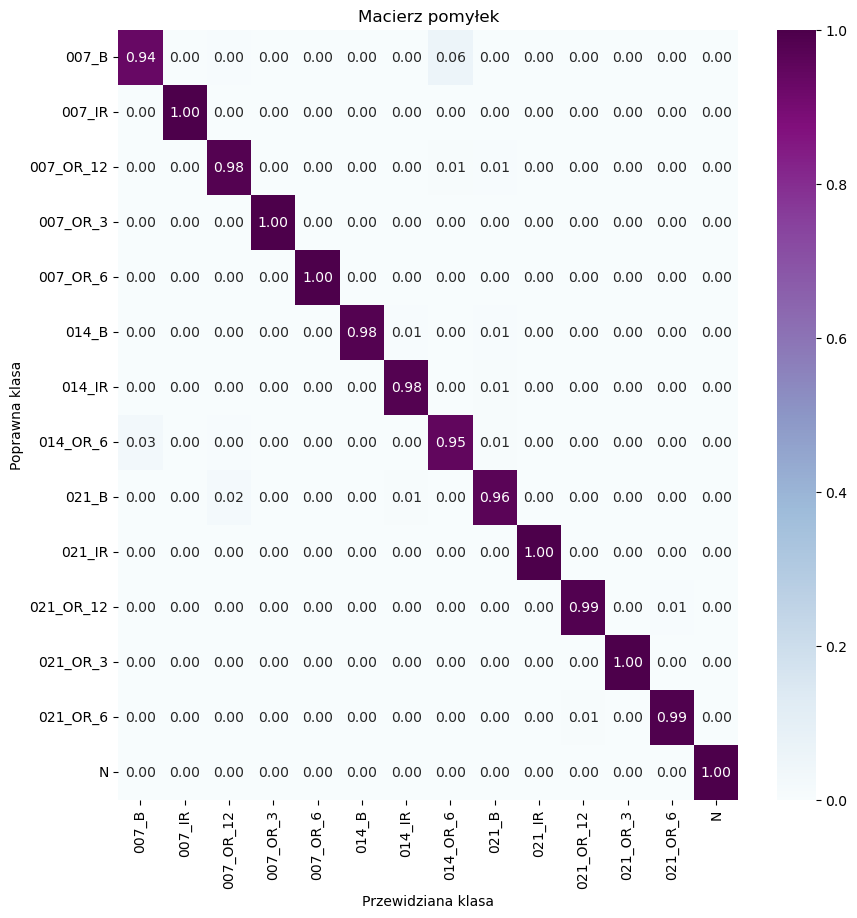

In [23]:
from sklearn.metrics import confusion_matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1) # Przekształcanie predykcji z formatu one-hot na etykiety klas
    y_pred = encoder.inverse_transform(y_pred) # Inwersja kodowania etykiet na oryginalne wartości
    return y_pred

y_pred=cnn_model.predict(X_test) # Generowanie predykcji modelu

# Przekształcanie wyników predykcji i prawdziwych etykiet
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)

# Tworzenie macierzy pomyłek
plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True ,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [24]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, Y_pred)
print(score)

0.9840155363011652


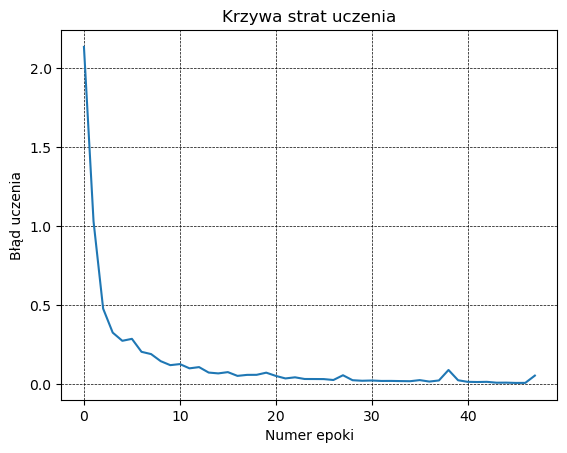

In [25]:
# Wyświetlanie krzywej strat uczenia
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

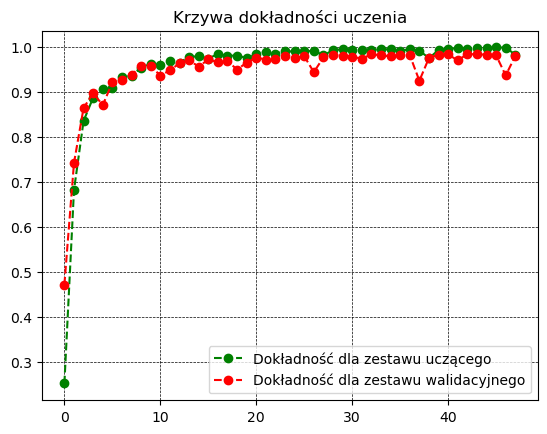

In [26]:
# Wyświetlanie krzywej dokładności uczenia
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

489/489 [==============================] - 5s 9ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15617 samples in 0.003s...
[t-SNE] Computed neighbors for 15617 samples in 1.845s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15617
[t-SNE] Computed conditional probabilities for sample 2000 / 15617
[t-SNE] Computed conditional probabilities for sample 3000 / 15617
[t-SNE] Computed conditional probabilities for sample 4000 / 15617
[t-SNE] Computed conditional probabilities for sample 5000 / 15617
[t-SNE] Computed conditional probabilities for sample 6000 / 15617
[t-SNE] Computed conditional probabilities for sample 7000 / 15617
[t-SNE] Computed conditional probabilities for sample 8000 / 15617
[t-SNE] Computed conditional probabilities for sample 9000 / 15617
[t-SNE] Computed conditional probabilities for sample 10000 / 15617
[t-SNE] Computed conditional probabilities for sample 11000 / 15617
[t-SNE] Computed conditional probabilities for sample 12000 / 

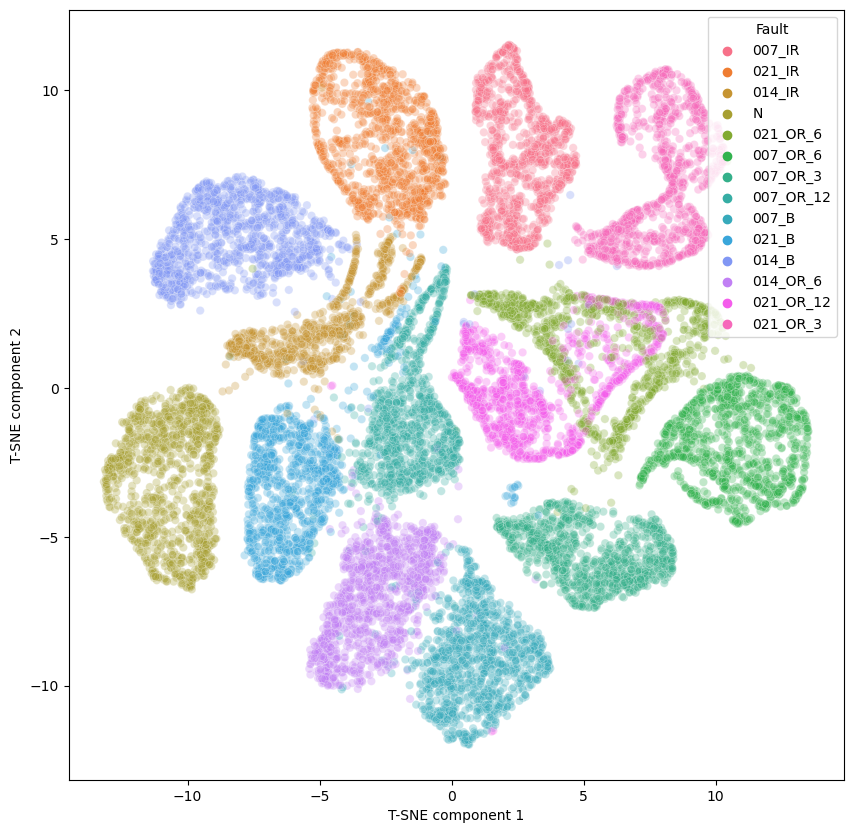

In [27]:
from sklearn.manifold import TSNE

# Tworzenie modelu pomocniczego, który zwraca wyjście z piątej warstwy oryginalnego modelu CNN
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)

# Przepuszczanie danych treningowych przez pomocniczy model, aby uzyskać wyniki z piątej warstwy
y_viz = dummy_cnn.predict(X_train)

# Użycie algorytmu t-SNE do redukcji wymiarowości danych wyjściowych do dwóch wymiarów
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

# Tworzenie DataFrame z wynikami t-SNE, z kolumnami dla dwóch wymiarów t-SNE
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

# Przekształcanie etykiet z formatu one-hot do oryginalnych etykiet i dodawanie ich do DataFrame
tSNEdf['Fault']=inv_Transform_result(y_train)


# Wizualizacja wyników t-SNE za pomocą wykresu punktowego
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [28]:
df = pd.read_csv('2hp_all_faults.csv')

In [29]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Parametry okna i przesunięcia
win_len=784
stride=300

# Inicjalizacja list do przechowywania segmentów danych i etykiet
X=[]
Y=[]

# Przetwarzanie danych dla każdej unikalnej wartości w kolumnie 'fault'
for k in df['fault'].unique():
    
    # Filtracja danych dla bieżącej wartości 'fault'
    df_temp_2 = df[df['fault']==k]
    
    # Ekstrakcja segmentów danych o długości 'win_len' przesuwanych o 'stride'
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        # Pobieranie segmentu danych i przekształcanie go do odpowiedniego formatu
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp) # Dodawanie segmentu do listy X
        Y.append(df_temp_2.iloc[i+win_len,-1]) # Dodawanie etykiety do listy Y
        
# Konwersja list X i Y do tablic numpy    
X=np.array(X)
X=X.reshape((X.shape[0],28,28,1)) # Przekształcenie do formatu (liczba_segmentów, 28, 28, 1)

Y=np.array(Y)  # Konwersja listy Y do tablicy numpy

# Kodowanie etykiet za pomocą LabelEncoder
encoder= LabelEncoder()
encoder.fit(Y) # Dopasowanie encoder'a do etykiet
encoded_Y = encoder.transform(Y) # Transformacja etykiet do wartości numerycznych
OHE_Y = to_categorical(encoded_Y)  # Konwersja etykiet do postaci one-hot

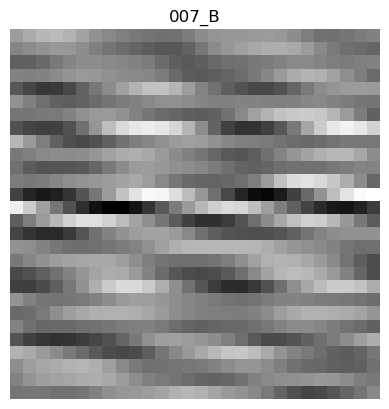

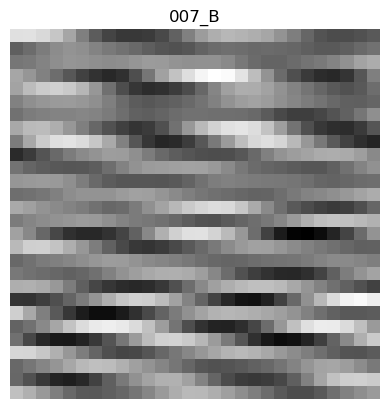

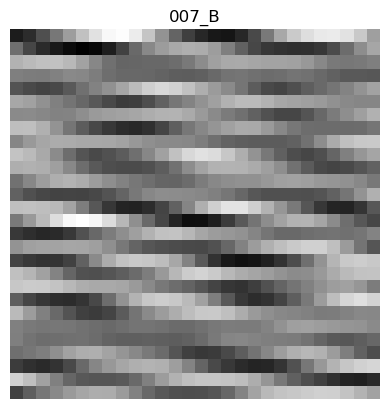

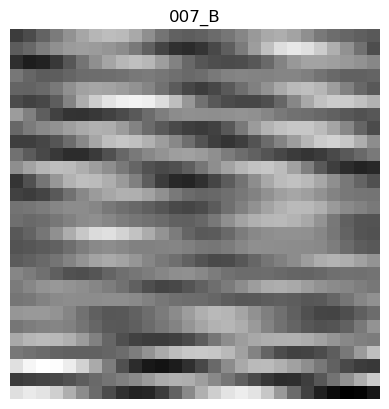

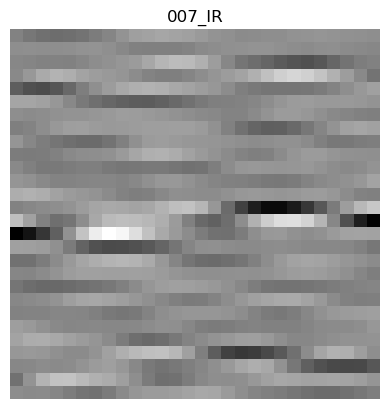

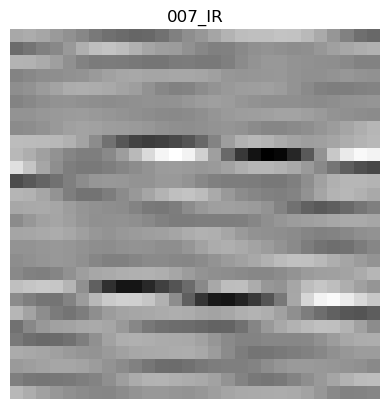

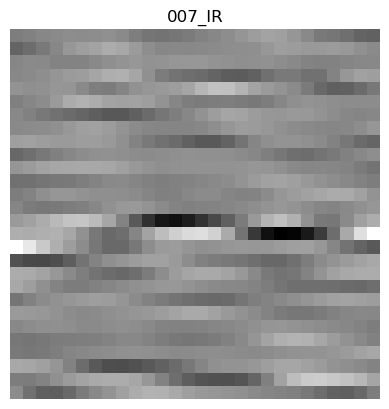

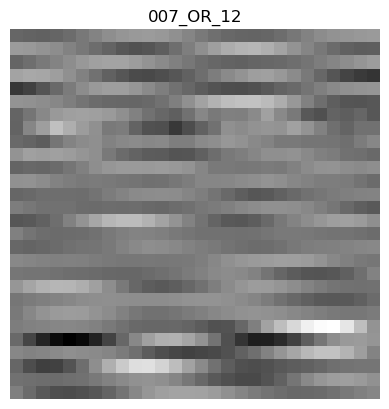

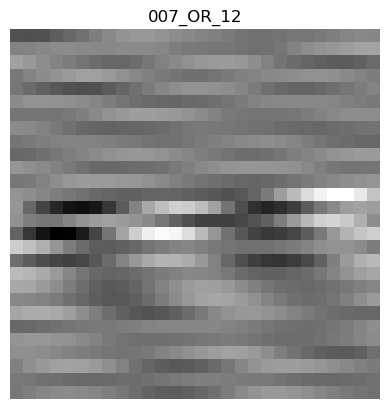

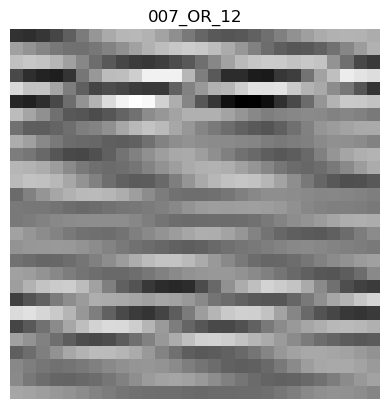

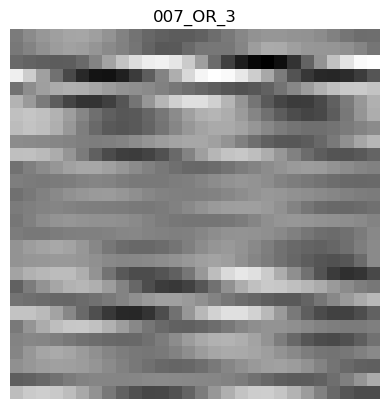

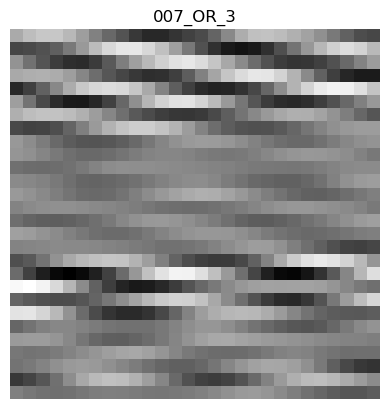

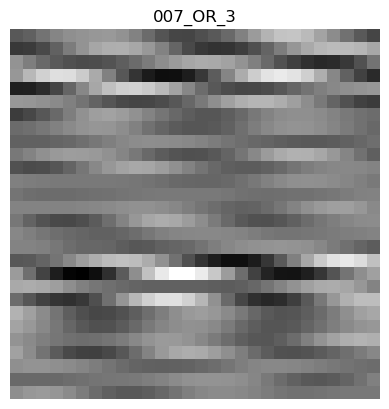

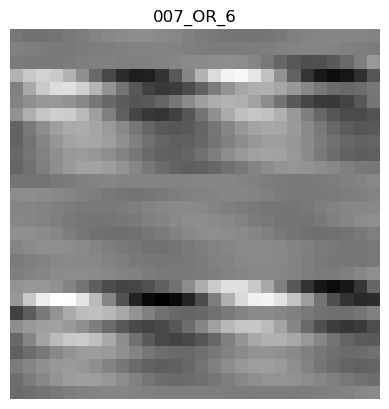

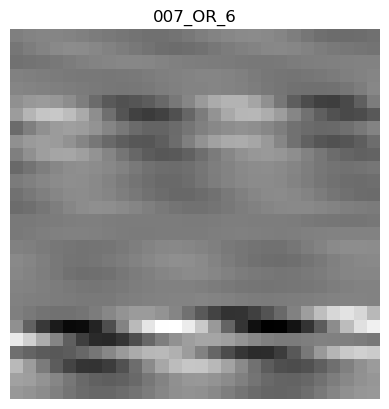

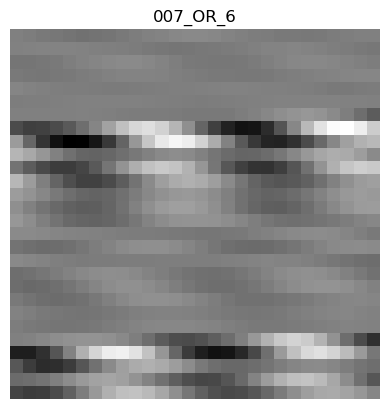

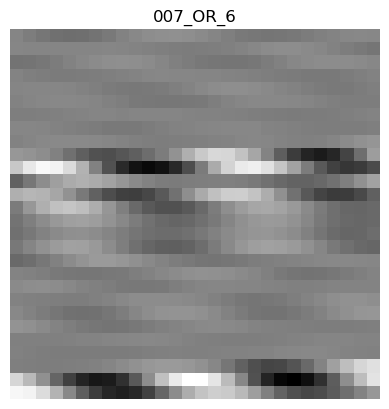

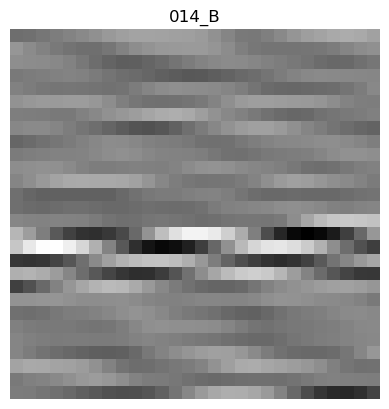

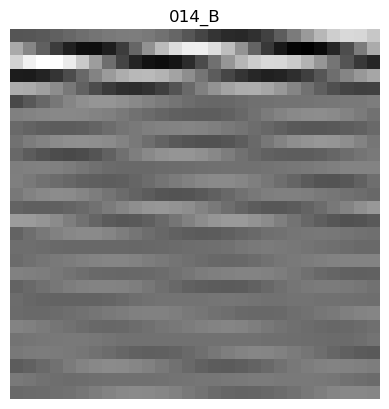

In [30]:
from matplotlib.pyplot import imread

# Pętla przez wybrane indeksy segmentów
# range(0, 9244, 500) oznacza, że pętla przechodzi przez indeksy od 0 do 9244 z krokiem 500
for idx in range(0,9244,500):
    img=X[idx]
    # Wyświetlanie obrazu za pomocą matplotlib
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [31]:
from sklearn.model_selection import train_test_split
# Podział danych na zbiory treningowy i testowy
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [32]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          51232     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 120)              

In [34]:
# Definicja wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trening modelu z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodanie wczesnego zatrzymywania do listy callbacks
)

Epoch 1/80
40/40 [==============================] - 12s 275ms/step - loss: 2.1592 - accuracy: 0.2744 - val_loss: 1.7052 - val_accuracy: 0.4717
Epoch 2/80
40/40 [==============================] - 11s 273ms/step - loss: 1.2453 - accuracy: 0.6264 - val_loss: 0.8709 - val_accuracy: 0.6908
Epoch 3/80
40/40 [==============================] - 11s 275ms/step - loss: 0.6880 - accuracy: 0.7557 - val_loss: 0.6098 - val_accuracy: 0.7870
Epoch 4/80
40/40 [==============================] - 11s 274ms/step - loss: 0.4858 - accuracy: 0.8283 - val_loss: 0.4498 - val_accuracy: 0.8348
Epoch 5/80
40/40 [==============================] - 11s 275ms/step - loss: 0.3957 - accuracy: 0.8549 - val_loss: 0.3517 - val_accuracy: 0.8671
Epoch 6/80
40/40 [==============================] - 11s 273ms/step - loss: 0.3176 - accuracy: 0.8854 - val_loss: 0.3185 - val_accuracy: 0.8800
Epoch 7/80
40/40 [==============================] - 11s 275ms/step - loss: 0.2835 - accuracy: 0.8946 - val_loss: 0.2905 - val_accuracy: 0.8928

213/213 [==============================] - 2s 11ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

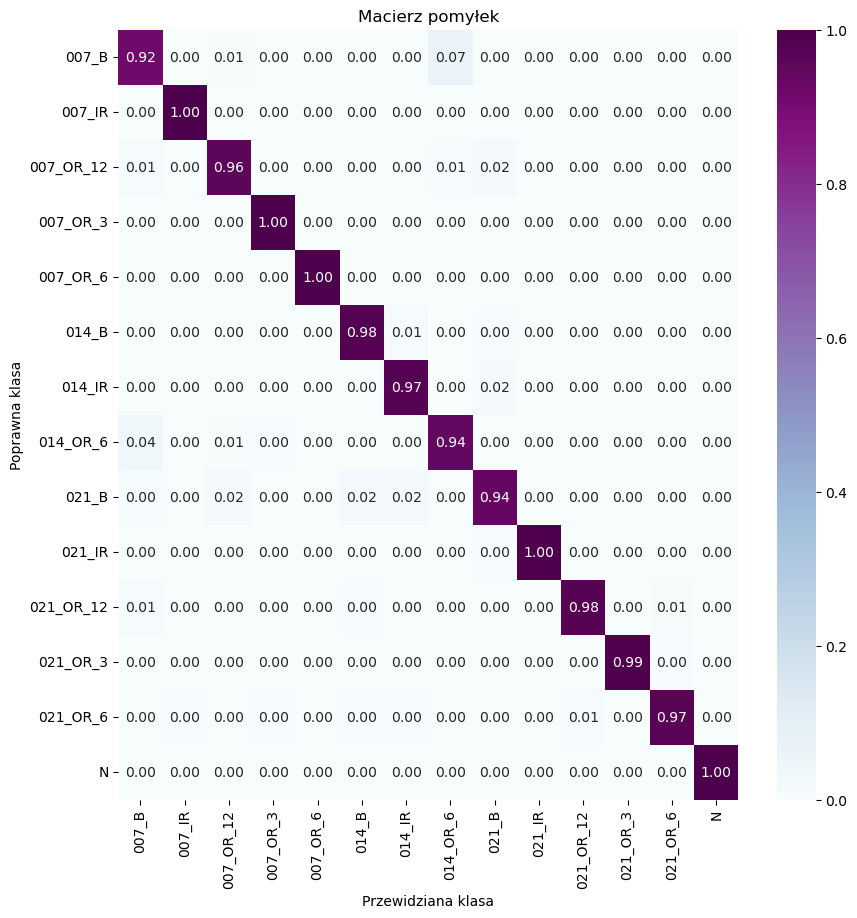

In [35]:
from sklearn.metrics import confusion_matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1) # Przekształcanie predykcji z formatu one-hot na etykiety klas
    y_pred = encoder.inverse_transform(y_pred) # Inwersja kodowania etykiet na oryginalne wartości
    return y_pred

y_pred=cnn_model.predict(X_test) # Generowanie predykcji modelu

# Przekształcanie wyników predykcji i prawdziwych etykiet
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)

# Tworzenie macierzy pomyłek
plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True ,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [36]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, Y_pred)
print(score)

0.9744418331374853


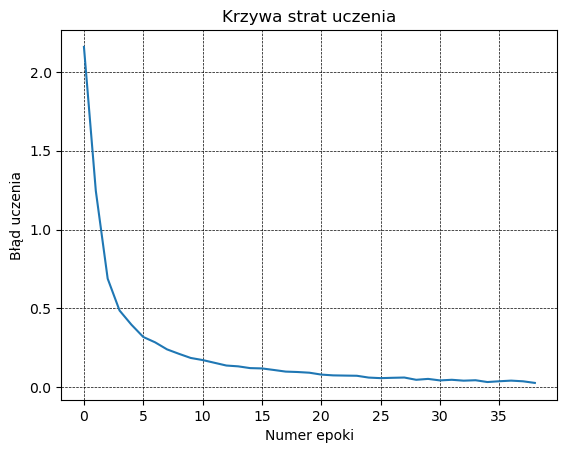

In [37]:
# Wyświetlanie krzywej strat uczenia
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

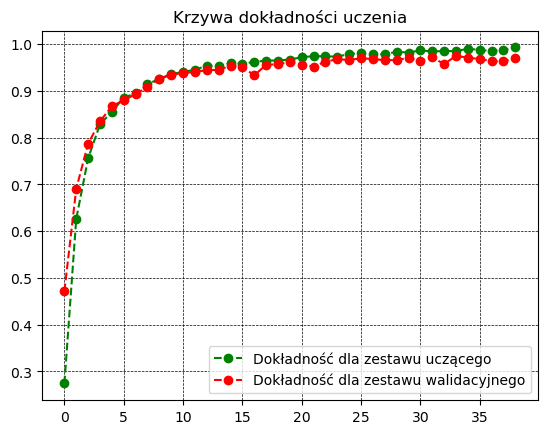

In [38]:
# Wyświetlanie krzywej dokładności uczenia
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

497/497 [==============================] - 5s 10ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15884 samples in 0.000s...
[t-SNE] Computed neighbors for 15884 samples in 2.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15884
[t-SNE] Computed conditional probabilities for sample 2000 / 15884
[t-SNE] Computed conditional probabilities for sample 3000 / 15884
[t-SNE] Computed conditional probabilities for sample 4000 / 15884
[t-SNE] Computed conditional probabilities for sample 5000 / 15884
[t-SNE] Computed conditional probabilities for sample 6000 / 15884
[t-SNE] Computed conditional probabilities for sample 7000 / 15884
[t-SNE] Computed conditional probabilities for sample 8000 / 15884
[t-SNE] Computed conditional probabilities for sample 9000 / 15884
[t-SNE] Computed conditional probabilities for sample 10000 / 15884
[t-SNE] Computed conditional probabilities for sample 11000 / 15884
[t-SNE] Computed conditional probabilities for sample 12000 /

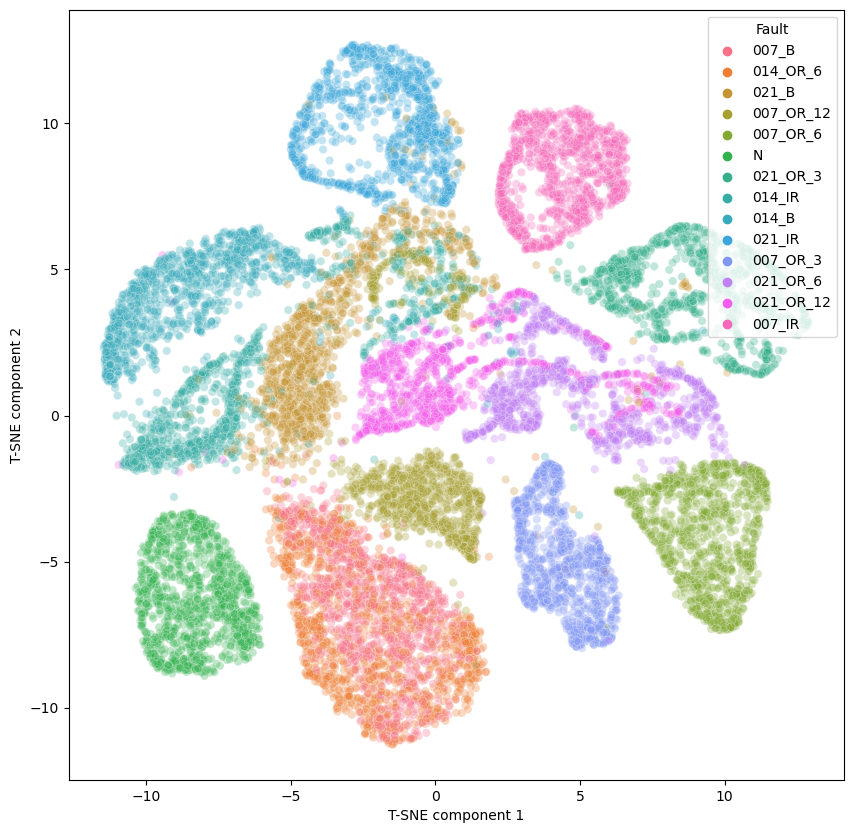

In [39]:
from sklearn.manifold import TSNE

# Tworzenie modelu pomocniczego, który zwraca wyjście z piątej warstwy oryginalnego modelu CNN
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)

# Przepuszczanie danych treningowych przez pomocniczy model, aby uzyskać wyniki z piątej warstwy
y_viz = dummy_cnn.predict(X_train)

# Użycie algorytmu t-SNE do redukcji wymiarowości danych wyjściowych do dwóch wymiarów
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

# Tworzenie DataFrame z wynikami t-SNE, z kolumnami dla dwóch wymiarów t-SNE
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

# Przekształcanie etykiet z formatu one-hot do oryginalnych etykiet i dodawanie ich do DataFrame
tSNEdf['Fault']=inv_Transform_result(y_train)


# Wizualizacja wyników t-SNE za pomocą wykresu punktowego
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [40]:
df = pd.read_csv('3hp_all_faults.csv')

In [41]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Parametry okna i przesunięcia
win_len=784
stride=300

# Inicjalizacja list do przechowywania segmentów danych i etykiet
X=[]
Y=[]

# Przetwarzanie danych dla każdej unikalnej wartości w kolumnie 'fault'
for k in df['fault'].unique():
    
    # Filtracja danych dla bieżącej wartości 'fault'
    df_temp_2 = df[df['fault']==k]
    
    # Ekstrakcja segmentów danych o długości 'win_len' przesuwanych o 'stride'
    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        # Pobieranie segmentu danych i przekształcanie go do odpowiedniego formatu
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp) # Dodawanie segmentu do listy X
        Y.append(df_temp_2.iloc[i+win_len,-1]) # Dodawanie etykiety do listy Y
        
# Konwersja list X i Y do tablic numpy    
X=np.array(X)
X=X.reshape((X.shape[0],28,28,1)) # Przekształcenie do formatu (liczba_segmentów, 28, 28, 1)

Y=np.array(Y)  # Konwersja listy Y do tablicy numpy

# Kodowanie etykiet za pomocą LabelEncoder
encoder= LabelEncoder()
encoder.fit(Y) # Dopasowanie encoder'a do etykiet
encoded_Y = encoder.transform(Y) # Transformacja etykiet do wartości numerycznych
OHE_Y = to_categorical(encoded_Y)  # Konwersja etykiet do postaci one-hot

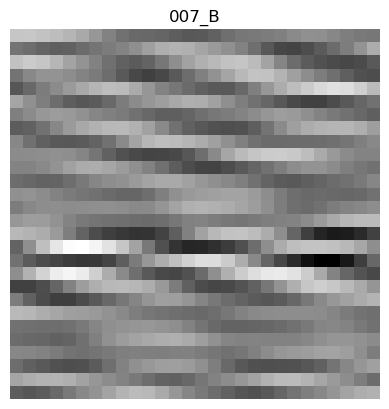

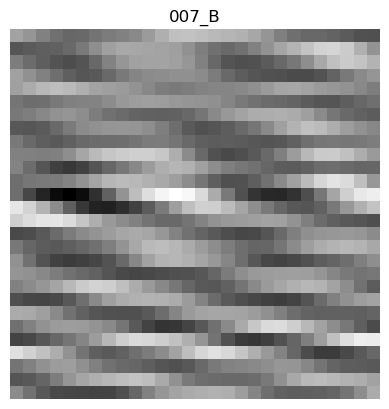

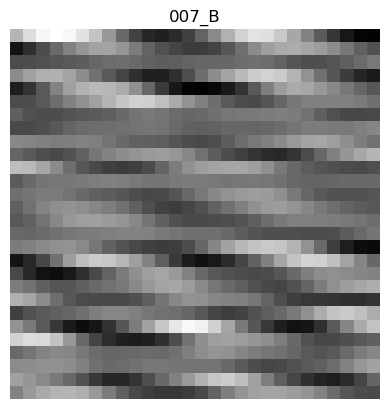

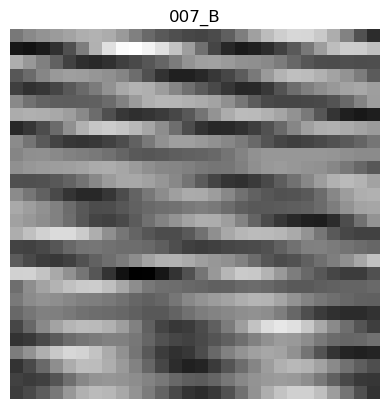

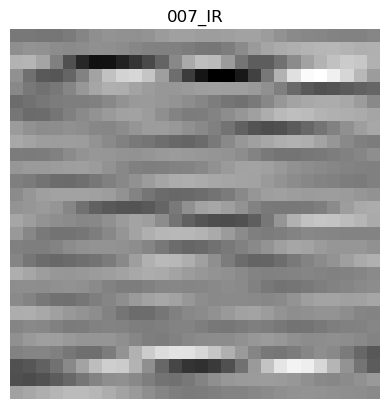

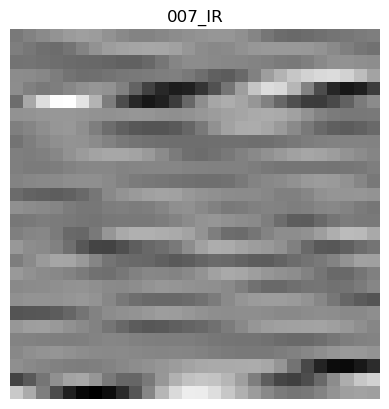

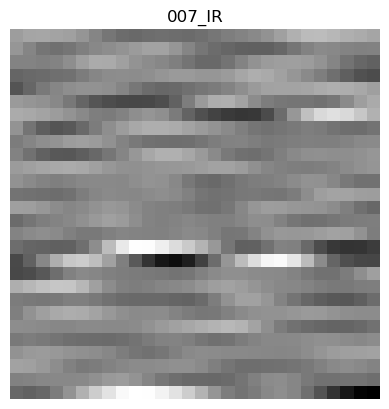

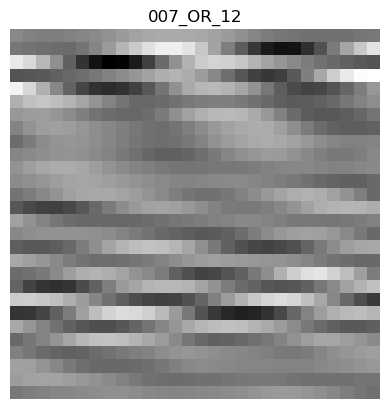

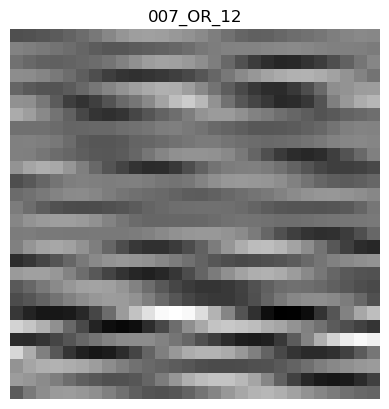

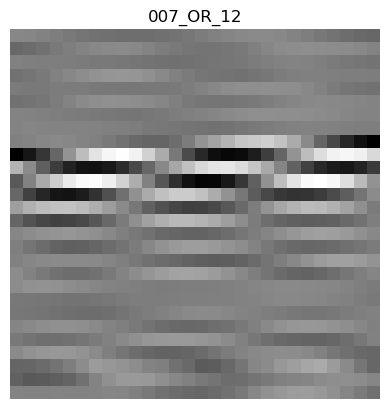

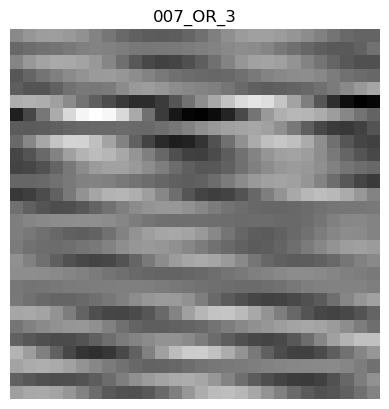

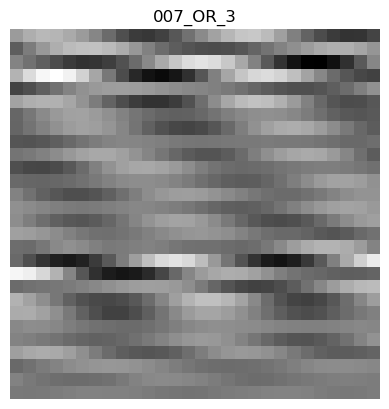

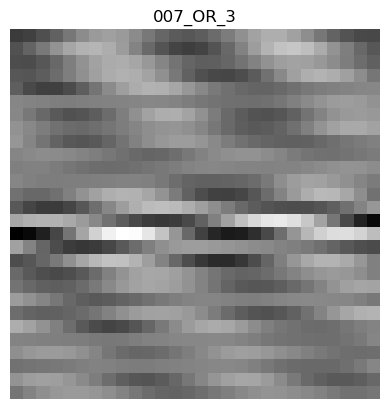

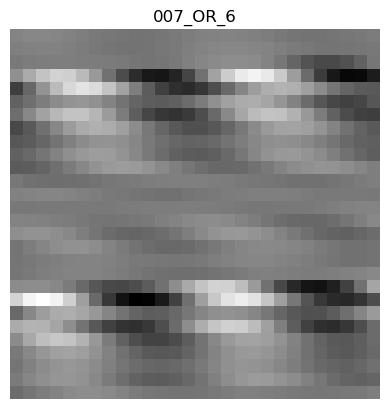

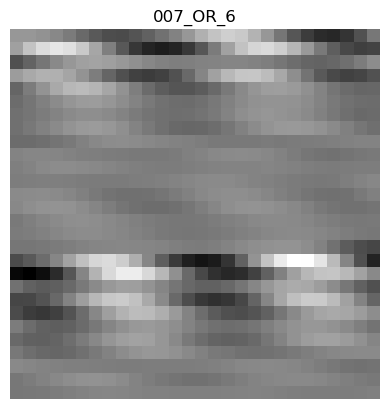

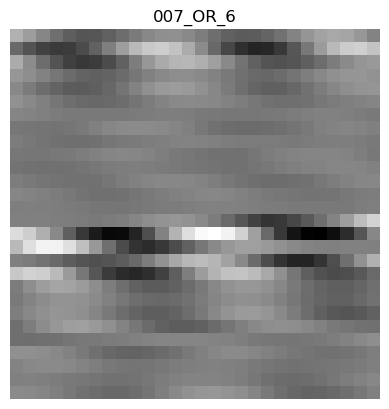

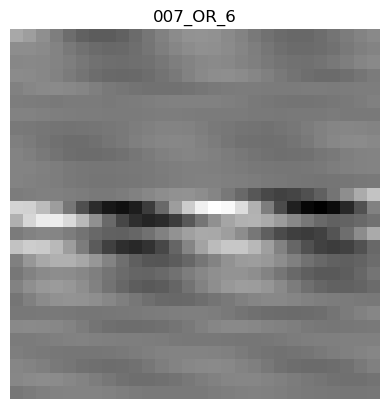

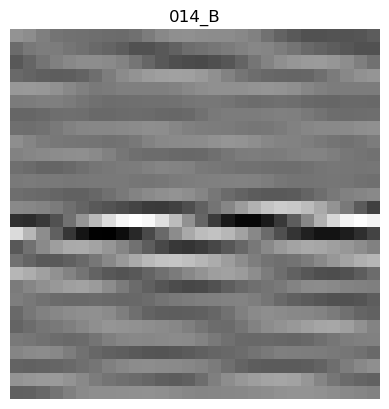

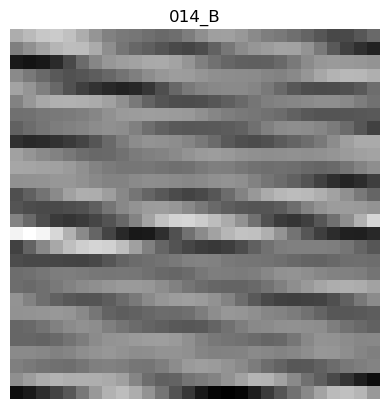

In [42]:
from matplotlib.pyplot import imread

# Pętla przez wybrane indeksy segmentów
# range(0, 9244, 500) oznacza, że pętla przechodzi przez indeksy od 0 do 9244 z krokiem 500
for idx in range(0,9244,500):
    img=X[idx]
    # Wyświetlanie obrazu za pomocą matplotlib
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [43]:
from sklearn.model_selection import train_test_split
# Podział danych na zbiory treningowy i testowy
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [44]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [45]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 32)          51232     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [46]:
# Definicja wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trening modelu z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodanie wczesnego zatrzymywania do listy callbacks
)

Epoch 1/80
40/40 [==============================] - 13s 279ms/step - loss: 2.2014 - accuracy: 0.2462 - val_loss: 1.6795 - val_accuracy: 0.4760
Epoch 2/80
40/40 [==============================] - 12s 289ms/step - loss: 1.1811 - accuracy: 0.6200 - val_loss: 0.8263 - val_accuracy: 0.7326
Epoch 3/80
40/40 [==============================] - 11s 274ms/step - loss: 0.6353 - accuracy: 0.7804 - val_loss: 0.5534 - val_accuracy: 0.8090
Epoch 4/80
40/40 [==============================] - 11s 276ms/step - loss: 0.4504 - accuracy: 0.8407 - val_loss: 0.3989 - val_accuracy: 0.8601
Epoch 5/80
40/40 [==============================] - 11s 277ms/step - loss: 0.3721 - accuracy: 0.8640 - val_loss: 0.3821 - val_accuracy: 0.8641
Epoch 6/80
40/40 [==============================] - 11s 278ms/step - loss: 0.3303 - accuracy: 0.8782 - val_loss: 0.3104 - val_accuracy: 0.8891
Epoch 7/80
40/40 [==============================] - 11s 279ms/step - loss: 0.2884 - accuracy: 0.8967 - val_loss: 0.3483 - val_accuracy: 0.8738

213/213 [==============================] - 3s 11ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

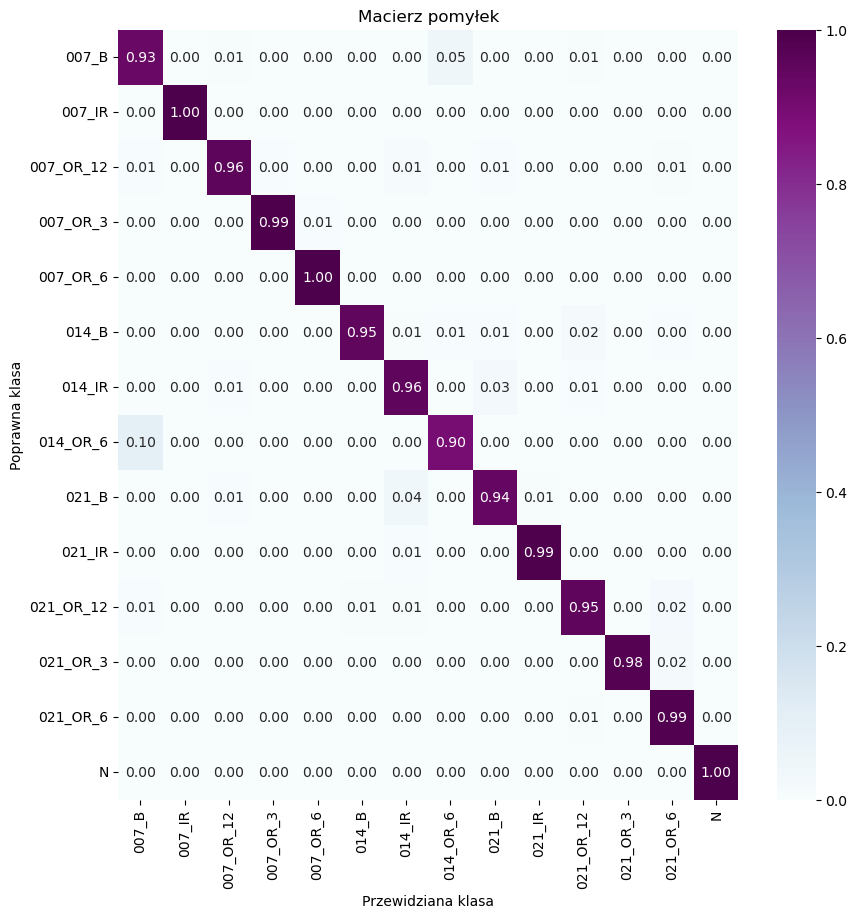

In [47]:
from sklearn.metrics import confusion_matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1) # Przekształcanie predykcji z formatu one-hot na etykiety klas
    y_pred = encoder.inverse_transform(y_pred) # Inwersja kodowania etykiet na oryginalne wartości
    return y_pred

y_pred=cnn_model.predict(X_test) # Generowanie predykcji modelu

# Przekształcanie wyników predykcji i prawdziwych etykiet
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)

# Tworzenie macierzy pomyłek
plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True ,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

In [48]:
from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, Y_pred)
print(score)

0.9665050683120318


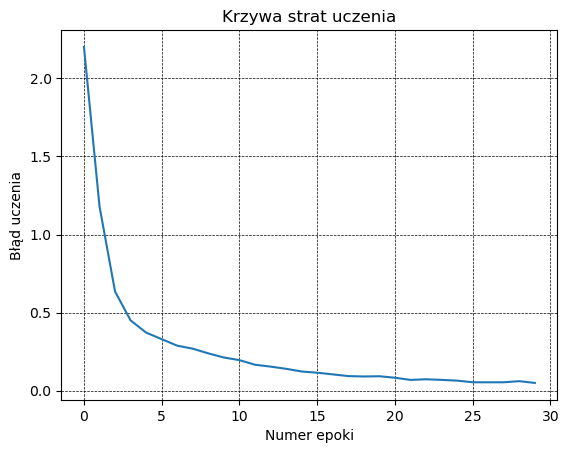

In [49]:
# Wyświetlanie krzywej strat uczenia
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

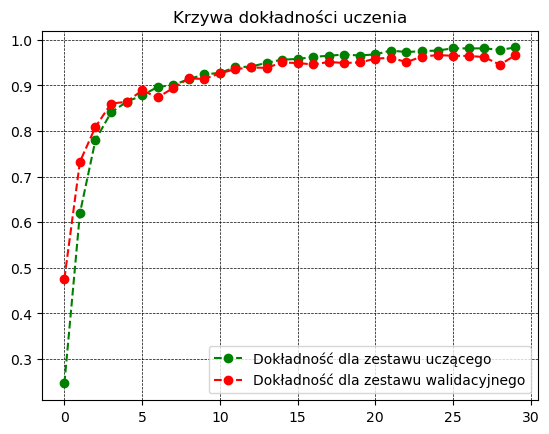

In [50]:
# Wyświetlanie krzywej dokładności uczenia
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

497/497 [==============================] - 5s 11ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15880 samples in 0.002s...
[t-SNE] Computed neighbors for 15880 samples in 2.169s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15880
[t-SNE] Computed conditional probabilities for sample 2000 / 15880
[t-SNE] Computed conditional probabilities for sample 3000 / 15880
[t-SNE] Computed conditional probabilities for sample 4000 / 15880
[t-SNE] Computed conditional probabilities for sample 5000 / 15880
[t-SNE] Computed conditional probabilities for sample 6000 / 15880
[t-SNE] Computed conditional probabilities for sample 7000 / 15880
[t-SNE] Computed conditional probabilities for sample 8000 / 15880
[t-SNE] Computed conditional probabilities for sample 9000 / 15880
[t-SNE] Computed conditional probabilities for sample 10000 / 15880
[t-SNE] Computed conditional probabilities for sample 11000 / 15880
[t-SNE] Computed conditional probabilities for sample 12000 /

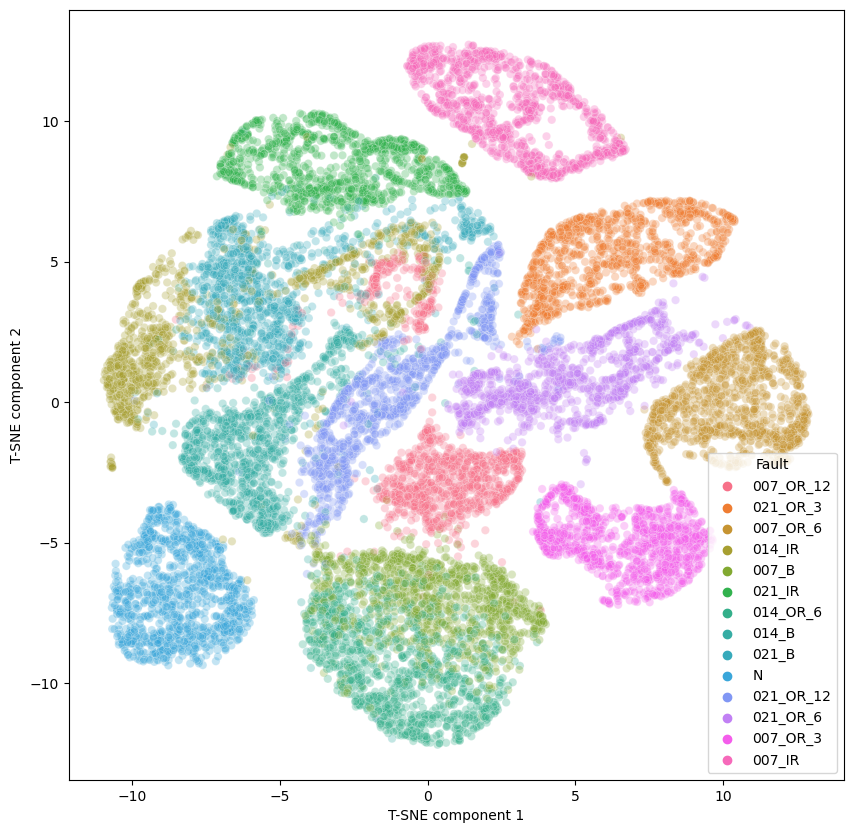

In [51]:
from sklearn.manifold import TSNE

# Tworzenie modelu pomocniczego, który zwraca wyjście z piątej warstwy oryginalnego modelu CNN
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)

# Przepuszczanie danych treningowych przez pomocniczy model, aby uzyskać wyniki z piątej warstwy
y_viz = dummy_cnn.predict(X_train)

# Użycie algorytmu t-SNE do redukcji wymiarowości danych wyjściowych do dwóch wymiarów
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

# Tworzenie DataFrame z wynikami t-SNE, z kolumnami dla dwóch wymiarów t-SNE
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

# Przekształcanie etykiet z formatu one-hot do oryginalnych etykiet i dodawanie ich do DataFrame
tSNEdf['Fault']=inv_Transform_result(y_train)


# Wizualizacja wyników t-SNE za pomocą wykresu punktowego
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

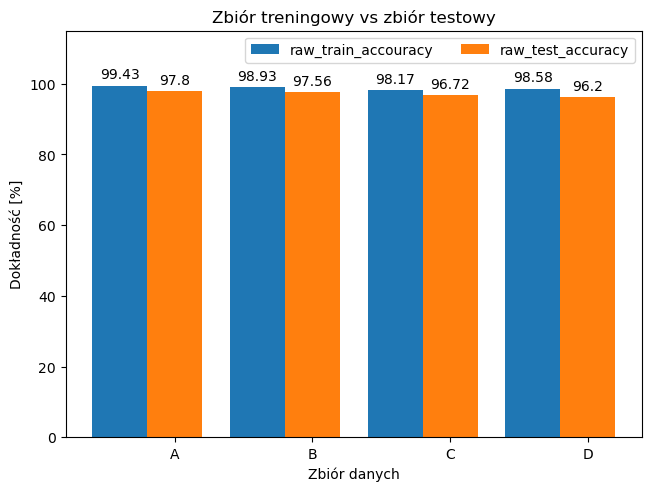

In [52]:
# Definiowanie danych
models = ('A', 'B', 'C', 'D') 
raw_data = {'raw_train_accouracy' : (99.43, 98.93, 98.17, 98.58),
'raw_test_accuracy' : (97.80, 97.56, 96.72, 96.20),
}

# Przygotowanie danych do wykresu
x = np.arange(len(models))
width = 0.4
multiplier = 0

# Tworzenie wykresu
fig, ax = plt.subplots(layout = 'constrained')
for attribute, measurement in raw_data.items():
    offset = width * multiplier
    rects= ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1
    
# Ustawienia osi i legendy   
ax.set_ylabel('Dokładność [%]')
ax.set_xlabel('Zbiór danych')
ax.set_title('Zbiór treningowy vs zbiór testowy')
ax.set_xticks(x + width, models)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 115)
plt.show()
